In [1]:
import cv2
import numpy as np
from numpy.core.defchararray import join, mod
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import os
import torch
from torch._C import device
from torch.autograd.grad_mode import F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from PIL import Image
from torchvision import transforms as torchtrans 

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec  5 11:01:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
labels_path = '/content/drive/MyDrive/guns_object_detection/Labels'
imgs_path = '/content/drive/MyDrive/guns_object_detection/Images'

In [53]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class gun(Dataset):
    def __init__(self,imgs_path,labels_path):

        self.imgs_path = imgs_path
        self.labels_path = labels_path
        self.img_name = [img for img in sorted(os.listdir(self.imgs_path))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]

    def __getitem__(self,idx):

        image_path = os.path.join(self.imgs_path,str(self.img_name[idx]))
        img = cv2.imread(image_path)
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).to(device)
        img_res = img_res.permute(2, 0, 1)
        
        label_name = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.labels_path,str(label_name))
        with open(label_path, 'r') as label_file:
            l_count = int(label_file.readline())
            box = []
            for i in range(l_count):
                box.append(list(map(int, label_file.readline().split())))

        target={}
        target["boxes"] = torch.as_tensor(box).to(device)
        area = []
        for i in range(len(box)):
           
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])
            area.append(a)
        target["area"] = torch.as_tensor(area).to(device)
        labels = []
        for i in range(len(box)):
            labels.append(1)

        target["image_id"] = torch.as_tensor([idx]).to(device)
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64).to(device)


        return img_res,target

    def __len__(self):
        return len(self.img_name)

In [54]:
def model(num):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features, num)
    return model


def collate_fn(batch):
    return tuple(zip(*batch))

# 모델 학습

In [55]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations # 평균값

    def reset(self): # 초기화
        self.current_total = 0.0
        self.iterations = 0.0
        
loss_hist = Averager() 

In [56]:
gun_data = gun(imgs_path, labels_path)
data_load = DataLoader(gun_data, batch_size=5,
                       shuffle=True, num_workers=0, collate_fn=collate_fn)
num_class = 2
model = model(num_class)
model.to(device)
num_epoch = 10
init_epoch = 0
param = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.SGD(param,lr=0.01,momentum=0.9)

lr_scheduler = None
for epoch in range(num_epoch):
    loss_num = 0
    model.train()
    loss_hist.reset()
    for img, target in data_load:
        loss_dic = model(img, target)
        loss = sum(loss for loss in loss_dic.values())

        loss_value = loss.item()
        loss_hist.send(loss_value)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_num += loss
        
    if lr_scheduler is not None:
        lr_scheduler.step()
    print("epoch:{},loss:{}".format(epoch, loss_num))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

epoch:0,loss:16.07625389099121
epoch:1,loss:10.429712295532227
epoch:2,loss:8.541509628295898
epoch:3,loss:7.071902751922607
epoch:4,loss:6.024279594421387
epoch:5,loss:5.384986877441406
epoch:6,loss:4.932961463928223
epoch:7,loss:4.618522644042969
epoch:8,loss:4.10795259475708
epoch:9,loss:3.594670534133911


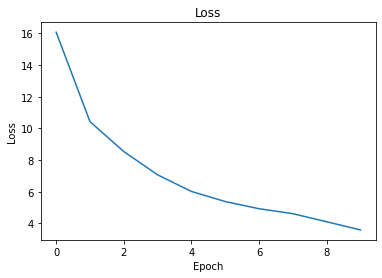

In [60]:
epoch = [i for i in range(10)]
loss = [16.07625389099121, 10.429712295532227, 8.541509628295898, 7.071902751922607, 6.024279594421387, 5.384986877441406, 4.932961463928223, 4.618522644042969, 4.10795259475708, 3.594670534133911]
plt.plot(epoch, loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss")
plt.show()

In [11]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
backbone.body.conv1.weight 	 torch.Size([64, 3, 7, 7])
backbone.body.bn1.weight 	 torch.Size([64])
backbone.body.bn1.bias 	 torch.Size([64])
backbone.body.bn1.running_mean 	 torch.Size([64])
backbone.body.bn1.running_var 	 torch.Size([64])
backbone.body.layer1.0.conv1.weight 	 torch.Size([64, 64, 1, 1])
backbone.body.layer1.0.bn1.weight 	 torch.Size([64])
backbone.body.layer1.0.bn1.bias 	 torch.Size([64])
backbone.body.layer1.0.bn1.running_mean 	 torch.Size([64])
backbone.body.layer1.0.bn1.running_var 	 torch.Size([64])
backbone.body.layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
backbone.body.layer1.0.bn2.weight 	 torch.Size([64])
backbone.body.layer1.0.bn2.bias 	 torch.Size([64])
backbone.body.layer1.0.bn2.running_mean 	 torch.Size([64])
backbone.body.layer1.0.bn2.running_var 	 torch.Size([64])
backbone.body.layer1.0.conv3.weight 	 torch.Size([256, 64, 1, 1])
backbone.body.layer1.0.bn3.weight 	 torch.Size([256])
backbone.body.layer1.0.bn3.bias 	 torch.Size([25

In [12]:
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
          [ 1.4377e-04, -3.1278e-04, -3.2387e-04],
          [-2.2573e-04, -2.3286e-04, -7.5164e-04]],

         [[-4.7103e-04, -5.1242e-04, -3.1108e-04],
          [-5.7856e-04, -7.9029e-04, -5.7344e-04],
          [ 1.6954e-04, -5.2689e-04, -7.4553e-04]],

         ...,

         [[-2.3865e-04,  1.3926e-04, -4.6168e-05],
          [-1.2649e-04,  5.2890e-04,  3.8801e-04],
          [-3.4790e-04, -3.2054e-04, -6.7688e-05]],

         [[ 1.6497e-04,  1.2846e-04,  1.4926e-04],
          [-8.5899e-05,  3.7027e-05,  1.2190e-05],
          [-8.9302e-05,  2.5313e-05, -1.0951e-04]],

         [[ 2.5612e-04,  1.0785e-04, -1.5196e-04],
          [ 4.1224e-05,  6.7469e-07, -2.4543e-05],
          [ 2.9841e-05, -6.9355e-05, -1.0060e-04]]],


        [[[ 5.8052e-04,  7.6468e-04,  9.7882e-04],
          [ 2.2037e-04,  1.1311e-04,  8.1739e-04],
          [-1.3322e-04,  3.5737e-04,  1.0565e-03]],

         [[ 3.8156e-04,  4.0820e-04,  1.9504e-04],
          [ 1.276

In [13]:
# Save model
TRAINED_MODEL_VERSION = "1.0a"
TRAINED_MODEL_FILENAME = "weapon_trained_model-"+TRAINED_MODEL_VERSION+".pt"
torch.save(model, TRAINED_MODEL_FILENAME)

Pretrained model and inference

# Model 1 (lr=0.01, epoch 10) Results

In [6]:
!ls content/weapon-trained-model -l

ls: cannot access 'content/weapon-trained-model': No such file or directory


In [7]:
# Load the model
# model = TheModelClass(*args, **kwargs)

LOAD_MODEL_VERSION = "1.0a"
LOAD_MODEL_FILENAME = "weapon_trained_model-"+LOAD_MODEL_VERSION+".pt"
LOAD_DIR = '/content/drive/MyDrive/'

cpu_device = torch.device("cpu")

# model.load_state_dict(torch.load(LOAD_DIR+LOAD_MODEL_FILENAME))
model= torch.load(LOAD_DIR+LOAD_MODEL_FILENAME, map_location=torch.device('cpu'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [8]:
model.to("cuda:0")

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
import matplotlib.patches as patches
def apply_nms(orig_prediction, iou_thresh=None):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep].detach().numpy()
    final_prediction['scores'] = final_prediction['scores'][keep].detach().numpy()
    final_prediction['labels'] = final_prediction['labels'][keep].detach().numpy()
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    count=0
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        
        # Draw the bounding box on top of the image
        a.add_patch(rect)

        a.add_artist(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0

        prediction = list(target['scores'])[count]
        count += 1

        a.annotate(prediction, (cx, cy), color='r', weight='bold', 
                    fontsize=12, ha='center', va='center')
        

    plt.show()

def plot_img_bbox_gt(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    count=0
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        
        # Draw the bounding box on top of the image
        a.add_patch(rect)

    plt.show()

In [10]:
test_path = '../input/guns-object-detection/Images'
test_data = gun(imgs_path, labels_path)
img,tar = test_data[42]
input = []
input.append(img)
outputs = model(input)

In [47]:
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
outputs

[{'boxes': tensor([[188.1263,  68.4213, 277.5528, 106.6357]], grad_fn=<ToCopyBackward0>),
  'labels': tensor([1]),
  'scores': tensor([0.9988], grad_fn=<ToCopyBackward0>)}]

Predicted


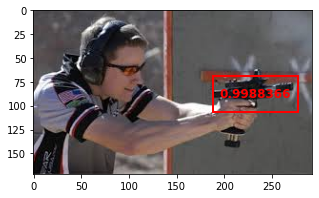

In [48]:
nms_prediction = apply_nms(outputs[0], iou_thresh=0.7)
print('Predicted')
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [49]:
tar['boxes'] = tar['boxes'].cpu()
tar['area'] = tar['area'].cpu()
tar['image_id'] = tar['image_id'].cpu()
tar['labels'] = tar['labels'].cpu()

Ground true


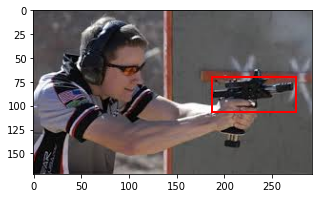

In [52]:
print("Ground true")
plot_img_bbox_gt(torch_to_pil(img), tar)

# 모든 데이터에 대한 prediction

In [11]:
test_path = '../input/guns-object-detection/Images'
test_data = gun(imgs_path, labels_path)
img,tar = test_data[0]
input = []
input.append(img)
outputs = model(input)

In [16]:
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
outputs

[{'boxes': tensor([[ 75.2677,  42.5000, 148.2220,  87.5253]], grad_fn=<ToCopyBackward0>),
  'labels': tensor([1]),
  'scores': tensor([0.9987], grad_fn=<ToCopyBackward0>)}]

In [26]:
max(outputs[0]['scores'].cpu().tolist())

0.9986591339111328

In [31]:
test_path = '../input/guns-object-detection/Images'
test_data = gun(imgs_path, labels_path)
prediction_scores = []
for i in range(333):
    img,tar = test_data[i]
    input = []
    input.append(img)
    outputs = model(input)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    outputs
    prediction_scores.append(min(outputs[0]['scores'].cpu().tolist()))

In [32]:
prediction_scores

[0.9986591339111328,
 0.9982889294624329,
 0.9978109002113342,
 0.06774075329303741,
 0.9989920258522034,
 0.998721182346344,
 0.9990811347961426,
 0.9988332390785217,
 0.9980103373527527,
 0.9976649284362793,
 0.5689932107925415,
 0.9965211153030396,
 0.9953077435493469,
 0.9989614486694336,
 0.9988877177238464,
 0.9983213543891907,
 0.998930037021637,
 0.9983142614364624,
 0.9964239001274109,
 0.9984283447265625,
 0.9960055947303772,
 0.9993941783905029,
 0.053323063999414444,
 0.16939105093479156,
 0.9990580677986145,
 0.9993890523910522,
 0.9973021745681763,
 0.9991618394851685,
 0.07269337773323059,
 0.9974713325500488,
 0.9977694749832153,
 0.05709310993552208,
 0.9983329176902771,
 0.9974563717842102,
 0.998314380645752,
 0.9980473518371582,
 0.9992801547050476,
 0.9988600015640259,
 0.9914996027946472,
 0.096897192299366,
 0.998399555683136,
 0.9966108202934265,
 0.9988365769386292,
 0.9990090131759644,
 0.9989206790924072,
 0.9990845918655396,
 0.9991071820259094,
 0.997131109

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


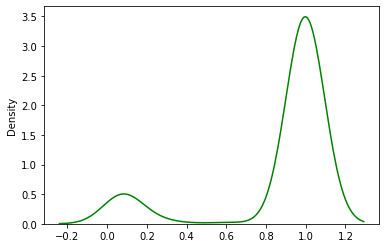

In [41]:
import seaborn as sns
sns.distplot(prediction_scores,color="green", hist=False)

In [40]:
prediction_scores

[0.9986591339111328,
 0.9982889294624329,
 0.9978109002113342,
 0.06774075329303741,
 0.9989920258522034,
 0.998721182346344,
 0.9990811347961426,
 0.9988332390785217,
 0.9980103373527527,
 0.9976649284362793,
 0.5689932107925415,
 0.9965211153030396,
 0.9953077435493469,
 0.9989614486694336,
 0.9988877177238464,
 0.9983213543891907,
 0.998930037021637,
 0.9983142614364624,
 0.9964239001274109,
 0.9984283447265625,
 0.9960055947303772,
 0.9993941783905029,
 0.053323063999414444,
 0.16939105093479156,
 0.9990580677986145,
 0.9993890523910522,
 0.9973021745681763,
 0.9991618394851685,
 0.07269337773323059,
 0.9974713325500488,
 0.9977694749832153,
 0.05709310993552208,
 0.9983329176902771,
 0.9974563717842102,
 0.998314380645752,
 0.9980473518371582,
 0.9992801547050476,
 0.9988600015640259,
 0.9914996027946472,
 0.096897192299366,
 0.998399555683136,
 0.9966108202934265,
 0.9988365769386292,
 0.9990090131759644,
 0.9989206790924072,
 0.9990845918655396,
 0.9991071820259094,
 0.997131109

# 새로운 데이터로 테스트

In [43]:

class gun_test(Dataset):
    def __init__(self,imgs_path,labels_path):

        self.imgs_path = imgs_path
        self.labels_path = labels_path
        self.img_name = [img for img in sorted(os.listdir(self.imgs_path))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]

    def __getitem__(self,idx):

        image_path = os.path.join(self.imgs_path,str(self.img_name[idx]))
        img = cv2.imread(image_path)
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).to(device)
        img_res = img_res.permute(2, 0, 1)
        
        label_name = self.img_name[idx][:-4] + ".txt"
        label_path = os.path.join(self.labels_path,str(label_name))
        with open(label_path, 'r') as label_file:
            l_count = int(label_file.readline())
            box = []
            for i in range(l_count):
                box.append(list(map(int, label_file.readline().split())))

        target={}
        target["boxes"] = torch.as_tensor(box).to(device)
        area = []
        for i in range(len(box)):
           
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])
            area.append(a)
        target["area"] = torch.as_tensor(area).to(device)
        labels = []
        for i in range(len(box)):
            labels.append(1)

        target["image_id"] = torch.as_tensor([idx]).to(device)
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64).to(device)


        return img_res,target

In [42]:
test_imgs_path = '/content/drive/MyDrive/guns_object_detection/Test_Images'
test_labels_path = '/content/drive/MyDrive/guns_object_detection/Test_Labels'

In [44]:
test_path = '/content/drive/MyDrive/guns_object_detection/Images'
test_data = gun_test(test_imgs_path, test_labels_path)
img,tar = test_data[0]
input = []
input.append(img)
outputs = model(input)

In [46]:
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
outputs

[{'boxes': tensor([[ 75.6395,  77.2885, 329.6143, 297.5410],
          [ 76.5311,  62.9991, 203.3284, 308.5332],
          [198.8124,  94.5207, 331.0097, 217.3049]], grad_fn=<ToCopyBackward0>),
  'labels': tensor([1, 1, 1]),
  'scores': tensor([0.8669, 0.5601, 0.2090], grad_fn=<ToCopyBackward0>)}]

In [47]:
outputs[0]

{'boxes': tensor([[ 75.6395,  77.2885, 329.6143, 297.5410],
         [ 76.5311,  62.9991, 203.3284, 308.5332],
         [198.8124,  94.5207, 331.0097, 217.3049]], grad_fn=<ToCopyBackward0>),
 'labels': tensor([1, 1, 1]),
 'scores': tensor([0.8669, 0.5601, 0.2090], grad_fn=<ToCopyBackward0>)}

Predicted


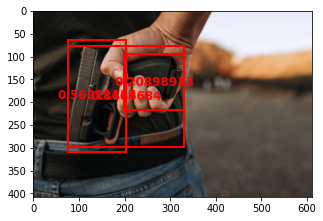

In [48]:
nms_prediction = apply_nms(outputs[0], iou_thresh=0.7)
print('Predicted')
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [49]:
nms_prediction

{'boxes': array([[ 75.63947 ,  77.28849 , 329.61426 , 297.54102 ],
        [ 76.531136,  62.999146, 203.32838 , 308.53317 ],
        [198.81244 ,  94.52074 , 331.0097  , 217.30492 ]], dtype=float32),
 'labels': array([1, 1, 1]),
 'scores': array([0.8668684 , 0.56011134, 0.20898913], dtype=float32)}